*For this mini-project of using Spark, the following will be done:*  
* Non-parametric t-test (Mood's median test for the main research)
  * between Intel and AMD scores while 

In [1]:
!pip install -q findspark
!pip install pyspark==2.4.7

Spark Initiation

In [1]:
APP_NAME = "3DMark"
SPARK_URL = "local[*]"

In [16]:
import pyspark
import pyspark.sql.functions as func
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName(APP_NAME).getOrCreate()

The dataset below is a list of results from 3DMark's Time Spy that I scraped myself for the first until the third capstone.

In [17]:
data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("combined_csv.csv")

In [18]:
data.show(10)

+--------+---------+-----------------+-----------+---------+--------------+---------+---------+--------+---------+--------------------+----------+-------+-------+-----------------+--------------------+------------------+---------------------+------------+--------------+---------+-----------------+------------------+-----------------+---------+--------------------+--------+-----+-----+--------------------+--------------------+-----+--------------+-----+--------------------+
|      id|benchmark|benchmark_version|cmbnd_score|cmbnd_fps|cpu_clock_freq|cpu_cores|cpu_litho|cpu_make|cpu_score|             cpu_sku|cpu_socket|cpu_tdp|cpu_fps|             date|                 gpu|gpu_avg_clock_freq|gpu_avg_memclock_freq|gpu_avg_temp|gpu_clock_freq|gpu_count|gpu_driver_status|gpu_driver_version|gpu_memclock_freq|gpu_score|          gpu_vendor|gpu_vram|  gt1|  gt2|         motherboard|                  os|  ram|ram_clock_freq|score|             storage|
+--------+---------+-----------------+------

In [19]:
data = data.na.drop() #dropping nulls

In [20]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- benchmark: string (nullable = true)
 |-- benchmark_version: double (nullable = true)
 |-- cmbnd_score: double (nullable = true)
 |-- cmbnd_fps: double (nullable = true)
 |-- cpu_clock_freq: string (nullable = true)
 |-- cpu_cores: string (nullable = true)
 |-- cpu_litho: integer (nullable = true)
 |-- cpu_make: string (nullable = true)
 |-- cpu_score: integer (nullable = true)
 |-- cpu_sku: string (nullable = true)
 |-- cpu_socket: string (nullable = true)
 |-- cpu_tdp: integer (nullable = true)
 |-- cpu_fps: double (nullable = true)
 |-- date: string (nullable = true)
 |-- gpu: string (nullable = true)
 |-- gpu_avg_clock_freq: double (nullable = true)
 |-- gpu_avg_memclock_freq: double (nullable = true)
 |-- gpu_avg_temp: string (nullable = true)
 |-- gpu_clock_freq: integer (nullable = true)
 |-- gpu_count: integer (nullable = true)
 |-- gpu_driver_status: string (nullable = true)
 |-- gpu_driver_version: string (nullable = true)
 |-- gpu_m

Ideally, since I am only splitting the dataset by the CPU manufacturers, no additional EDA needs to be done unlike what I did for my capstones. All but *cpu_make* and *score* are to be dropped.

In [21]:
print((data.count(), len(data.columns)))

(576448, 35)


As it stands, this dataset has around 580k results - which is good for Spark/Pyspark caching functions.

## Splitting dataset between AMD and Intel CPUs

In [24]:
amd = data.filter(data["cpu_make"] == "AMD")
intel = data.filter(data["cpu_make"] == "Intel")

In [28]:
print((amd.count(), intel.count()))

(363561, 212884)


There is a notable difference in numbers post-split, but this should not be an issue after sampling the AMD set down to Intel's.

In [29]:
amd = amd.sample(.5855)
print(amd.count())

212802


## A/B Testing between AMD and Intel-powered computers with 3DMark Time Spy Scores

In [35]:
amd_ = amd.select(["cpu_make", "score"])
intel_ = intel.select(["cpu_make", "score"])

In [38]:
finalData = amd_.union(intel_)
finalData.printSchema()

root
 |-- cpu_make: string (nullable = true)
 |-- score: integer (nullable = true)



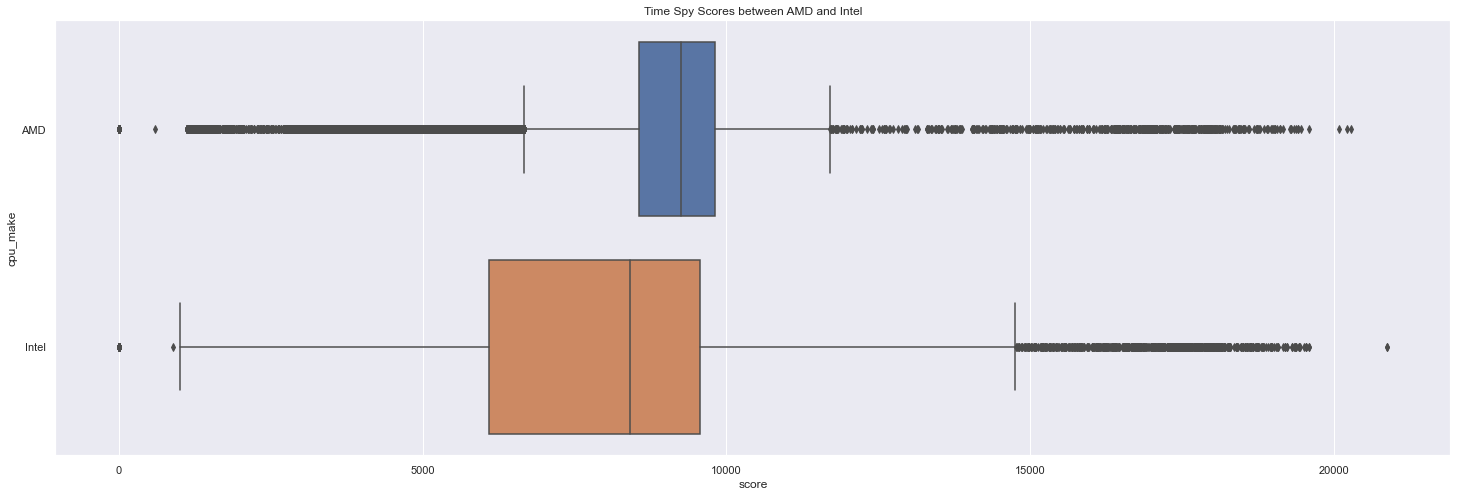

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25,8))
ts = sns.boxplot(data=finalData.toPandas(), x='score', y='cpu_make', orient='h')
ts.set_title('Time Spy Scores between AMD and Intel')
plt.show()

With the box plot above, it shows that Intel results have less outliers due to having a wider IQR from around 1000 to 15000 whereas AMD results mostly have 6000 to 12000 score. The outliers suggest that those systems are both higher- and lower-end, suggesting that those before Q1 are the laptops and those beyond Q3 are high-performing AMD systems, probably on the line of Ryzen X7XX CPUs and above with more powerful GPUs.

### Non-parametric Test

Now, we are about to establish to get to a conclusion and whether or not the null hypothesis should be rejected or accepted.

>$Ho$ - *There is no difference in performance between AMD and Intel systems in 3DMark's Time Spy.*

>$Ha$ - *There is a difference in performance between AMD and Intel systems in 3DMark's Time Spy.*

#### Mood's Median Test

In [52]:
import scipy.stats as stats

stat, p, med, tbl = stats.median_test(intel_.toPandas().score, amd_.toPandas().score)
print('p-value: {}\nmedian: {}'.format(p,med))

p-value: 0.0
median: 8979.0


Since the p-value is effectively 0, we can accept the alternative hypothesis which explicitly mentions that there, indeed, is a statistically significant difference between AMD and Intel systems in this 3DMark Time Spy dataset.